In [1]:
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve

from data_processing import DataLoader
from modeling import Modeling

#### Load Processed creditcard Data

In [2]:
loader = DataLoader("../data/processed/creditcard_cleaned.csv")
df = loader.load_data()

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data Preparation

In [3]:
DROP_COLS = [
    "Class"
]

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df["Class"]
print("Fraud rate:", y.mean())

Fraud rate: 0.001667101358352777


Initialize the modeling class

In [4]:
model = Modeling()

### Stratified train-test split

In [5]:
model.prepare_data(X, y)

X_train, X_test = model.X_train, model.X_test
y_train, y_test = model.y_train, model.y_test

### Baseline Model – Logistic Regression

In [6]:
print("Training Logistic Regression baseline...")
log_res_df = model.train_logistic_baseline()
display(log_res_df.drop(columns=["Confusion Matrix"]))

Training Logistic Regression baseline...


,Model,AUC-PR,F1,Precision,Recall,Best Threshold
0,Logistic Regression,0.671924,0.813559,0.878049,0.757895,1.0


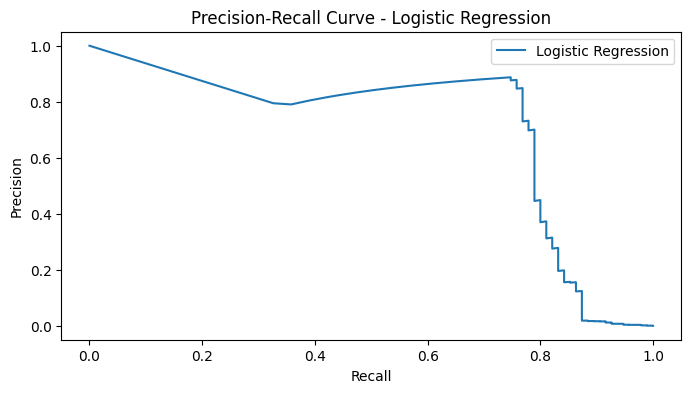

In [7]:
# PR curve for Logistic Regression
probs = model.models["Logistic Regression"].predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(8,4))
plt.plot(recall, precision, label="Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend()
plt.show()


### Ensemble Model – Random Forest with Hyperparameter Tuning

In [8]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None]
}

print("\nTraining Random Forest with hyperparameter tuning...")
rf_res_df = model.train_random_forest(param_grid)

display(rf_res_df.drop(columns=["Confusion Matrix"]))



Training Random Forest with hyperparameter tuning...


,Model,AUC-PR,F1,Precision,Recall,Best Threshold
0,Random Forest,0.808159,0.852273,0.925926,0.789474,0.195


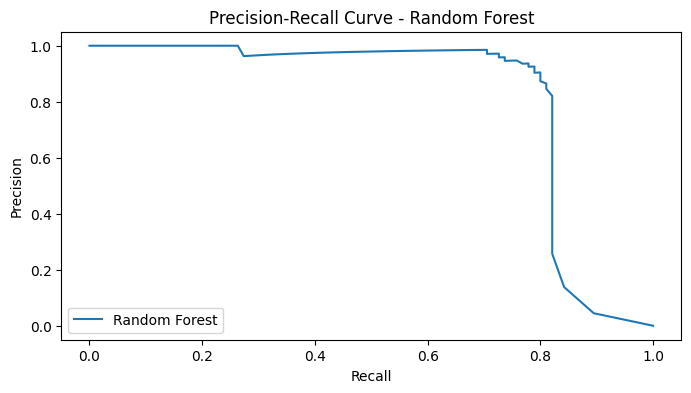

In [9]:
# PR curve
probs_rf = model.models["Random Forest"].predict_proba(X_test)[:, 1]
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, probs_rf)

plt.figure(figsize=(8,4))
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.show()


### Cross-Validation

In [10]:
cv_results = []

for model_name in model.models:
    mean_auc, std_auc = model.cross_validated_auc_pr(model_name, X, y)
    cv_results.append({
        "Model": model_name,
        "CV AUC-PR Mean": mean_auc,
        "CV AUC-PR Std": std_auc
    })

cv_results_df = pd.DataFrame(cv_results)
display(cv_results_df)


,Model,CV AUC-PR Mean,CV AUC-PR Std
0,Logistic Regression,0.731771,0.019081
1,Random Forest,0.834511,0.019015


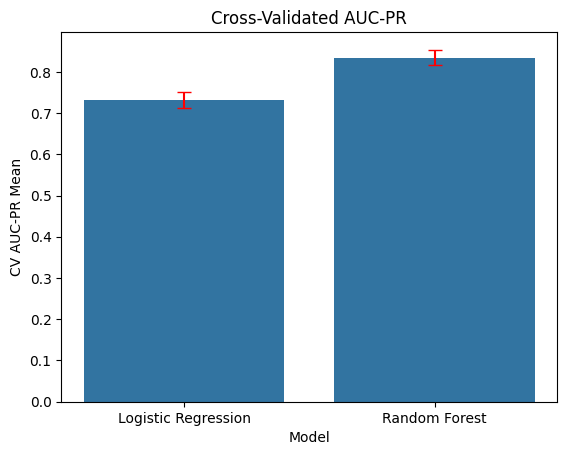

In [11]:
sns.barplot(x="Model", y="CV AUC-PR Mean", data=cv_results_df)
plt.errorbar(x=range(len(cv_results_df)), 
             y=cv_results_df["CV AUC-PR Mean"], 
             yerr=cv_results_df["CV AUC-PR Std"], 
             fmt='none', c='red', capsize=5)
plt.title("Cross-Validated AUC-PR")
plt.show()


### Model Comparison 

In [12]:
comparison_df = model.compare_models()

# Optional: drop the confusion matrix column for cleaner display
display(comparison_df.drop(columns=["Confusion Matrix"]))


,Model,AUC-PR,F1,Precision,Recall,Best Threshold
0,Random Forest,0.808159,0.852273,0.925926,0.789474,0.195
1,Logistic Regression,0.671924,0.813559,0.878049,0.757895,1.000


### Best Model Selection

In [13]:
best_model = comparison_df.iloc[0]
print("\nSelected Best Model:")
display(best_model)


Selected Best Model:


Model                        Random Forest
AUC-PR                            0.808159
F1                                0.852273
Precision                         0.925926
Recall                            0.789474
Best Threshold                       0.195
Confusion Matrix    [[56645, 6], [20, 75]]
Name: 0, dtype: object

In [14]:
os.makedirs("../models", exist_ok=True)

# Save baseline Logistic Regression
model.save_model(
    "Logistic Regression",
    "../models/logistic_regression_creditcard.pkl"
)

# Save final Random Forest model
model.save_model(
    "Random Forest",
    "../models/random_forest_creditcard.pkl"
)

print("Both models saved successfully.")


Both models saved successfully.


### Final Model Selection & Justification

After comparing the Logistic Regression (Baseline) and the Random Forest (Ensemble), the Random Forest is selected as the final model for deployment. 

##### Rationale

- **Predictive Superiority (AUC-PR)**: The Random Forest achieved a significantly higher AUC-PR of 0.81 compared to the baseline's 0.67. In the context of credit card fraud—where the "Fraud" class represents only 0.17% of the data—AUC-PR is the most critical metric because it measures the model's ability to catch true fraud while maintaining high precision.

- **Handling Complex Feature Interactions**: Credit card fraud patterns are rarely linear. The Random Forest is better equipped to identify complex, non-linear interactions within the anonymized PCA features (V1–V28) and the relationship between Transaction Amount and Time.

- **Balanced Business Impact**: Although the Random Forest requires more computational resources than a linear model, the trade-off is justified. The financial cost of a "False Negative" (failing to detect a high-value fraudulent transaction) far outweighs the incremental cost of the model's processing time.